In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/fitness.py
%run ../Scripts/coverage.py
%run ../Scripts/initMethods.py

In [2]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":           10000,
    "R0":              20,
    "M":                1, #Also L, total number of spacers
    "Np":               0,
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":               10, #cross-reactivity kernel
}

sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    160,
    "dx":                           1,
    "dt":                           1,
    "initial_mean_n":           [0,-80],
    "initial_var_n":               10,
    "initial_mean_nh":          [0,00],
    "initial_var_nh":              10,
    "conv_size":                  320,
    "num_threads":                  4,
}

In [3]:
def pred_value(params, sim_params):
    erf = scipy.special.erf
    var_nh = sim_params["initial_var_nh"]
    r = params["r"]
    const = np.exp(-var_nh**2/(2*np.power(r,2)))
    neg_exp = lambda x: (1/2)*np.exp(-x/r)
    pos_exp = lambda x: (1/2)*np.exp(x/r)

    div_const = 1/(var_nh*np.sqrt(2))
    erf_mean = var_nh**2/r
    neg_erf = lambda x: erf(div_const*(x-erf_mean))
    pos_erf = lambda x: erf(div_const*(x+erf_mean))

    def anal_result(x):
        return const*(neg_exp(x)*(neg_erf(x)+1)-pos_exp(x)*(pos_erf(x)-1))
    
    def anal_delay(x):
        return anal_result(x-erf_mean)
    return anal_delay

/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_8467/1392697183.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(n.todense(), label = "n", cmap = "Reds")
/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_8467/1392697183.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(nh.todense(), label = "nh", cmap = "Blues")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


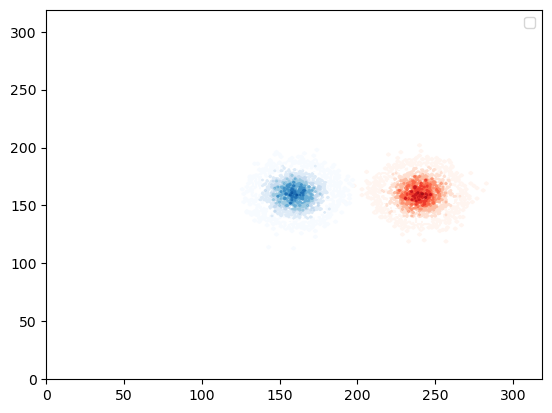

In [4]:
n = init_guassian(params["N0"], sim_params, "n")
nh = init_guassian(params["Nh"], sim_params, "nh")
kernel_quarter = init_quarter_kernel(params, sim_params)
kernel_full = init_full_kernel(params, sim_params)
plt.contour(n.todense(), label = "n", cmap = "Reds")
plt.contour(nh.todense(), label = "nh", cmap = "Blues")
plt.legend()
plt.show()

In [11]:
N = 1
params["r"] = 10
kernel_quarter = init_quarter_kernel(params, sim_params)

sum = np.zeros_like(nh.toarray()[160, :].squeeze(), dtype=float)

for i in range(N):
    nh = init_guassian(params["Nh"], sim_params, "nh")
    p_ele = elementwise_coverage(nh, n, kernel_quarter, params, sim_params)
    sum += p_ele.toarray()[160, :].squeeze()

y_averaged = sum/N


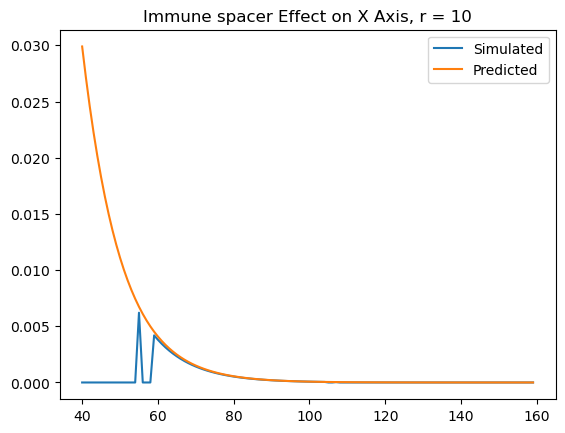

In [ ]:
# # plt.contour(np.mean(p.todense(), axis = 1))
# plt.plot(np.max(p_ele.toarray(), axis = 0).squeeze())
r = params["r"]
x_domain = sim_params["xdomain"]
dx = sim_params["dx"]
x_space = np.arange(-x_domain, x_domain, dx)

anal_func = pred_value(params, sim_params)
y_anal = anal_func(x_space)
# y_calc = p_ele.toarray()[160, :].squeeze()
y_calc = y_averaged

plt.plot(x_space[200:], y_calc[200:], label = "Simulated")
plt.plot(x_space[200:], y_anal[200:], label = "Predicted")
plt.title(f"Immune spacer Effect on X Axis, r = {r}")
plt.legend()

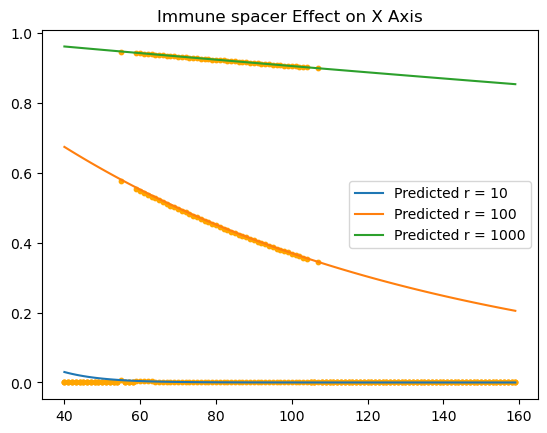

In [ ]:
params["r"] = r = 5
start_x = 200

for r in [10, 100, 1000]:
    params["r"] = r
    kernel_quarter = init_quarter_kernel(params, sim_params)

    p_ele = coverage_sparse_parrallel(nh, n, kernel_quarter, params, sim_params)
    y_calc = p_ele.toarray()[160, :].squeeze()

    anal_func = pred_value(params, sim_params)
    y_anal = anal_func(x_space)
    cut_xspace = x_space[start_x:]

    cut_yanal = y_anal[start_x:]
    # cut_yanal = cut_yanal/cut_yanal[0]

    cut_ycalc = y_calc[start_x:]
    # cut_ycalc = cut_ycalc/cut_yanal[0]

    plt.scatter(cut_xspace, cut_ycalc, color = "orange", s = 10)
    plt.plot(cut_xspace, cut_yanal, label = f"Predicted r = {r}")

plt.title(f"Immune spacer Effect on X Axis")
plt.legend()


In [ ]:
p_conv = coverage_parrallel_convolution(nh.todense(), n, kernel_full, params, sim_params)

In [ ]:
p_ele = coverage_sparse_parrallel(nh, n, kernel_quarter, params, sim_params)

In [ ]:
np.max(np.abs(p_ele-p_conv))

0.0020579735792621914

In [ ]:
input_data = nh.toarray()/(params["Nh"]*params["M"])
p_true = scipy.signal.convolve2d(input_data, kernel_full, mode="same")

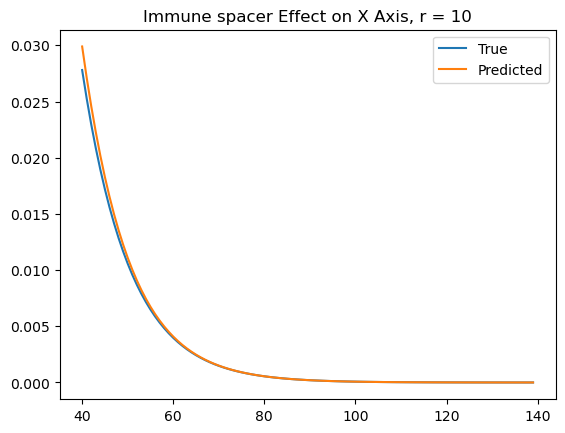

In [ ]:
r = params["r"]
x_domain = sim_params["xdomain"]
dx = sim_params["dx"]
x_space = np.arange(-x_domain, x_domain, dx)

mid_ele = p_ele.toarray()[160, :].squeeze()
mid_true = p_true[160, :].squeeze()
mid_conv = p_conv.toarray()[160, :].squeeze()
pred_func = pred_value(params, sim_params)
pred_values = pred_func(x_space)


# plt.plot(x_space[200:300], mid_ele[200:300], label = "Element")
plt.plot(x_space[200:300], mid_true[200:300], label = "True")
# plt.plot(x_space[200:300], mid_conv[200:300], label = "Slice")
plt.plot(x_space[200:300], pred_values[200:300], label = "Predicted")
plt.title(f"Immune spacer Effect on X Axis, r = {r}")
plt.legend()

In [ ]:
x_ind, _ = p_ele.nonzero()
x_ind2, _ = p_conv.nonzero()

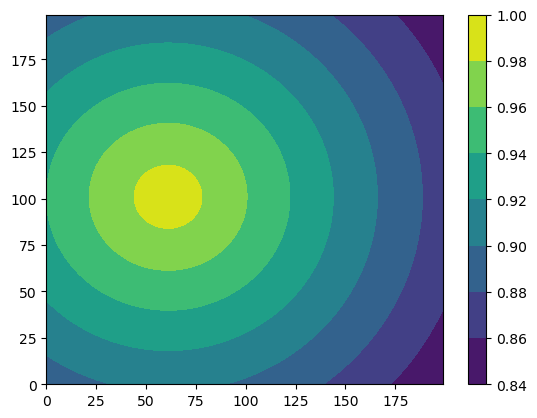

In [ ]:
Nh = params["Nh"]
# p = scipy.signal.convolve2d(nh.toarray()/Nh, kernel_full, mode="same")
plt.contourf(p_true)
plt.colorbar()

In [ ]:
f_new = fitness_spacers(n, nh, p_conv, params, sim_params)

In [ ]:
virus_growth(n, f_new, params, sim_params)

<320x320 sparse matrix of type '<class 'numpy.float64'>'
	with 2074 stored elements in Dictionary Of Keys format>